In [632]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio
import os

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [633]:
path = ''
image_path = os.path.join(path, './no_mask/')
mask_path = os.path.join(path, './mask/')

idx = np.random.randint(0, len(os.listdir(image_path)))

images = [image_path+i for i in os.listdir(image_path)]
masks = [mask_path+i for i in os.listdir(mask_path)]

In [634]:
def apply_mask(images, masks):
    os.makedirs('masked_images', exist_ok=True)

    for i, (img, msk) in enumerate(zip(images, masks)):
        image = iio.imread(img)
        mask = iio.imread(msk)
        masked_image = image.copy()
        masked_image[mask == True] = (0,0,0)
        
        img_path = os.path.join('masked_images', f"masked_img_{i:03d}.png")
        iio.imwrite(img_path, masked_image)

apply_mask(images, masks)

In [635]:
masked_path = os.path.join(path, './masked_images/')
masked_images = masked_images = [os.path.join(masked_path, i) for i in os.listdir(masked_path)]

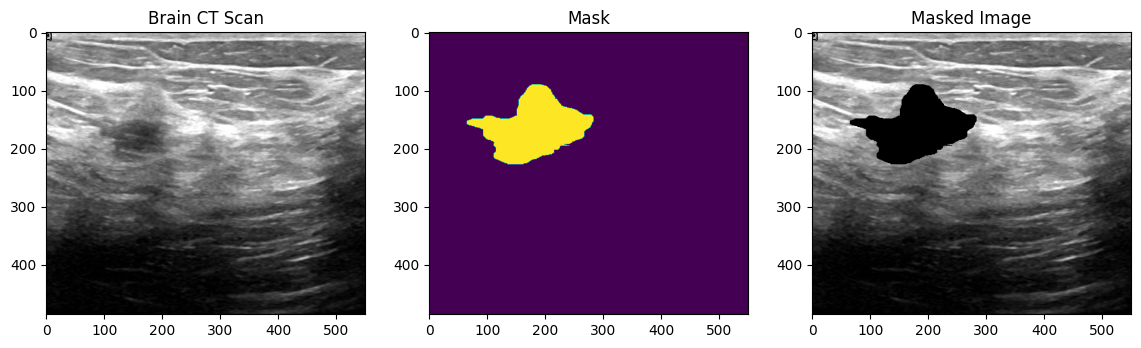

In [636]:
image = iio.imread(images[idx])
mask = iio.imread(masks[idx])
masked_image = iio.imread(masked_images[idx])

fig, ax = plt.subplots(1, 3, figsize=(14, 10))

ax[0].imshow(image)
ax[0].set_title("Brain CT Scan")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[2].imshow(masked_image)
ax[2].set_title("Masked Image")
plt.show()

In [762]:
# Augment the data
def augment_images(img, mask):
    img_mask = tf.concat([img, mask], axis=-1)  # Concatenate along channel axis
    img_mask = tf.image.flip_left_right(img_mask)  # Flip both at the same time
    img_mask = tf.image.flip_up_down(img_mask)  # Flip both at the same time
    
    img, mask = tf.split(img_mask, [img.shape[-1], mask.shape[-1]], axis=-1)  # Split back

    return img, mask

In [776]:
image_ds = tf.data.Dataset.from_tensor_slices((images, masks))
for img,msk in image_ds.take(1):
    print(img)
    print(msk)

tf.Tensor(b'./no_mask/malignant (1).png', shape=(), dtype=string)
tf.Tensor(b'./mask/malignant (1)_mask.png', shape=(), dtype=string)


In [777]:
def take_image_mask(image, masked):
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # scales it to be [0,1]

    masked = tf.io.read_file(masked)
    masked = tf.image.decode_png(masked, channels=3)
    masked = tf.image.convert_image_dtype(masked, tf.float32)
    masked = tf.reduce_max(masked, axis=-1, keepdims=True)

    image = tf.image.resize(image, (96,128), method='bilinear')
    masked = tf.image.resize(masked, (96, 128), method='bilinear')
    return image, masked

image_ds = image_ds.map(take_image_mask)
augmented_ds = image_ds.map(augment_images)

image_ds = image_ds.concatenate(augmented_ds)

In [778]:
def encoder_block(inputs, nfilters, dropout, max_pooling=True):
    x = Conv2D(nfilters, 
                  3,     
                  activation='relu',
                  padding='same')(inputs)

    x = Conv2D(nfilters, 
                  3, 
                  activation='relu',
                  padding='same')(x)

    if dropout > 0:
        x = Dropout(dropout)(x)

    if max_pooling:
        next_layer = MaxPooling2D((2,2))(x)
    else:
        next_layer = x
    
    skip = x

    return next_layer, skip

In [779]:
def upsample_block(input, skip, nfilters):
    x = Conv2DTranspose(nfilters, 
                        3, 
                        strides=2, 
                        activation='relu', 
                        padding='same')(input)
    
    skip_conn = concatenate([x, skip], axis=3)
    x = Conv2D(nfilters, 3, activation='relu', padding='same')(skip_conn)
    x = Conv2D(nfilters, 3, activation='relu', padding='same')(x)
    return x

In [780]:
def unet_model(input_size, n_filters=32):
    input = Input(input_size)

    s1, skip1 = encoder_block(input, n_filters, 0)
    s2, skip2 = encoder_block(s1, n_filters*2, 0)
    s3, skip3 = encoder_block(s2, n_filters*4, 0)
    s4, skip4 = encoder_block(s3, n_filters*8, 0)  
    s5, skip5 = encoder_block(s4, n_filters*16, dropout=0.2, max_pooling=False)

    b1 = upsample_block(s5, skip4, n_filters*8)
    b2 = upsample_block(b1, skip3, n_filters*4)
    b3 = upsample_block(b2, skip2, n_filters*2)
    b4 = upsample_block(b3, skip1, n_filters)

    output = Conv2D(32, 3, activation='relu', padding='same')(b4)

    final = Conv2D(1, 1, activation='sigmoid', padding='same')(b4)

    model = tf.keras.Model(inputs=input, outputs=final)

    return model

In [781]:
model = unet_model((96,128,3))
model.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_61      │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1182         │ (None, 96, 128,   │        896 │ input_layer_61[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1183         │ (None, 96, 128,   │      9,248 │ conv2d_1182[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_246   │ (None, 48, 64,    │          0 │ conv2d_1183[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1184         │ (None, 48, 64,    │     18,496 │ max_pooling2d_24… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1185         │ (None, 48, 64,    │     36,928 │ conv2d_1184[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_247   │ (None, 24, 32,    │          0 │ conv2d_1185[0][0] │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1186         │ (None, 24, 32,    │     73,856 │ max_pooling2d_24… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1187         │ (None, 24, 32,    │    147,584 │ conv2d_1186[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_248   │ (None, 12, 16,    │          0 │ conv2d_1187[0][0] │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1188         │ (None, 12, 16,    │    295,168 │ max_pooling2d_24… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1189         │ (None, 12, 16,    │    590,080 │ conv2d_1188[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_249   │ (None, 6, 8, 256) │          0 │ conv2d_1189[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1190         │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_24… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1191         │ (None, 6, 8, 512) │  2,359,808 │ conv2d_1190[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_74          │ (None, 6, 8, 512) │          0 │ conv2d_1191[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2… │ (None, 12, 16,    │  1,179,904 │ dropout_74[0][0]

 Total params: 8,630,497 (32.92 MB)

 Trainable params: 8,630,497 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [782]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

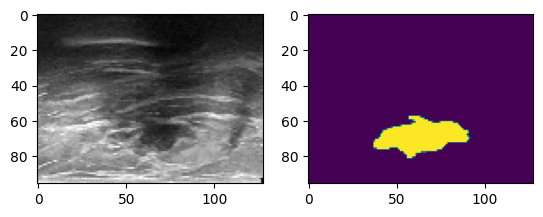

In [783]:
def print_image(img_list):
    for k,i in enumerate(img_list):
        plt.subplot(1, len(img_list), k+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(i))
    plt.show()

for img, msk in image_ds.skip(212).take(1):
    print_image([img, msk])

In [784]:
dataset_size = tf.data.experimental.cardinality(image_ds).numpy()
train_size = int(0.75 * dataset_size)  
val_size = dataset_size - train_size  

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size)

train_ds = train_ds.cache().batch(16).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(16).prefetch(tf.data.AUTOTUNE)

In [785]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(train_ds, epochs=5, validation_data=val_ds, verbose=1, callbacks=[early_stopping])

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 736ms/step - accuracy: 0.8457 - loss: 0.5484 - val_accuracy: 0.8602 - val_loss: 0.4141
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - accuracy: 0.8494 - loss: 0.4314 - val_accuracy: 0.8602 - val_loss: 0.3994
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.8494 - loss: 0.4177 - val_accuracy: 0.8602 - val_loss: 0.3751
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 711ms/step - accuracy: 0.8494 - loss: 0.4052 - val_accuracy: 0.8602 - val_loss: 0.3716


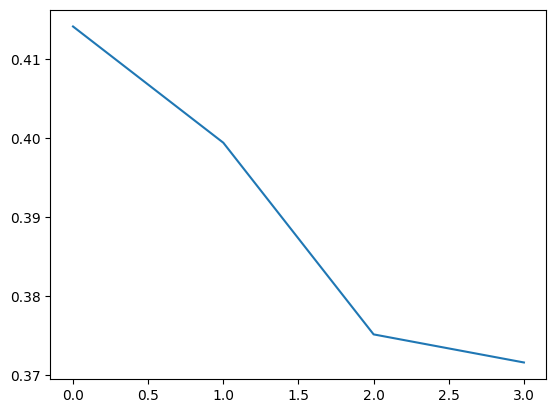

In [786]:
plt.plot(history.history['val_loss'], label='val')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


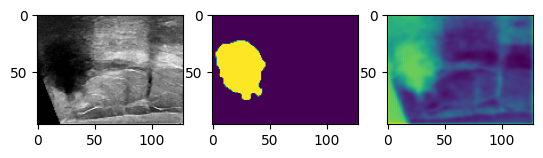

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


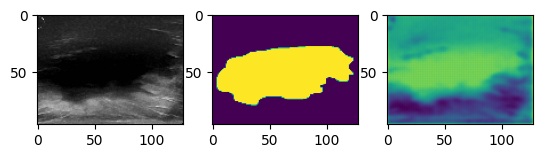

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


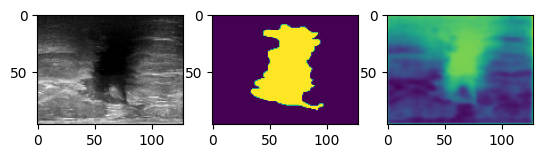

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


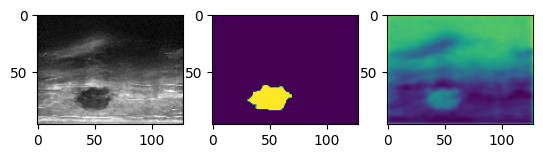

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


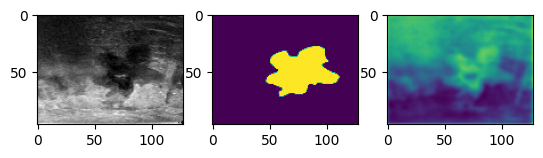

In [787]:
def predict(dataset, num_preds):
    if dataset:
        for img, msk in dataset.take(num_preds):
            pred = model.predict(img)
            pred = pred[0]  # Get the first image's mask from batch
            print_image([img[0], msk[0], pred])
            
predict(val_ds, 5)